# Simulation of production line with defects - Training

In this notebook we will train a Anomalib model using the Anomalib API and our own dataset. This notebook is also part of the Dobot series notebooks.

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>


| Class | Yellow cube | Red cube | Green cube | Inferencing using Anomalib
| --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| Normal | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> | 

Using Anomalib we are expecting to see this result.

## Imports

In [5]:
from __future__ import annotations

from pathlib import Path
from typing import Any

import numpy as np
from IPython.display import display
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

#For your own data
from anomalib.data.folder import Folder, FolderDataset
from anomalib.data.utils import InputNormalizationMethod, get_transforms

## Dataset
In the previous notebook XXXX we have created our dataset. Have in mind where your data is and include those paths below

In [3]:
# Prepare the path to save the new image and the anomalib results
dataset_path = "C:/Anomalib/datasets/cubes"

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration - Via config file

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above config; which is index 1 in the above dictionary. Let's take a quick look of its config file. 

In [6]:
MODEL = 'padim' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = f"cubes_config.yaml"
print(open(CONFIG_PATH, 'r').read())

# Replace the dataset configs with the following.
dataset:
  name: cubes
  format: folder
  path: ./datasets/cubes
  normal_dir: normal # name of the folder containing normal images.
  abnormal_dir: anormal # name of the folder containing abnormal images.
  task: classification # classification or segmentation
  mask: null #optional
  normal_test_dir: null # optional
  extensions: null
  split_ratio: 0.2  # normal images ratio to create a test split
  seed: 0
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  threshold:
    image_defaul

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [8]:
# pass the config file to model, logger, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = "../../datasets/cubes"     # or wherever the Custom Dataset is stored.
print(config)

{'dataset': {'name': 'cubes', 'format': 'folder', 'path': '../../datasets/cubes', 'normal_dir': 'normal', 'abnormal_dir': 'anormal', 'task': 'classification', 'mask': None, 'normal_test_dir': None, 'extensions': None, 'split_ratio': 0.2, 'seed': 0, 'image_size': [256, 256], 'train_batch_size': 32, 'test_batch_size': 32, 'num_workers': 8, 'transform_config': {'train': None, 'val': None, 'eval': None}, 'create_validation_set': True, 'tiling': {'apply': False, 'tile_size': None, 'stride': None, 'remove_border_count': 0, 'use_random_tiling': False, 'random_tile_count': 16}, 'val_split_mode': 'from_test', 'eval_batch_size': 32, 'test_split_ratio': 0.2, 'mask_dir': None, 'root': './datasets/cubes'}, 'model': {'name': 'padim', 'backbone': 'resnet18', 'layers': ['layer1', 'layer2', 'layer3'], 'normalization_method': 'min_max', 'input_size': [256, 256]}, 'metrics': {'image': ['F1Score', 'AUROC'], 'threshold': {'image_default': 3, 'pixel_default': 3, 'adaptive': True, 'method': 'adaptive', 'manu

## Configuration - Via API



# Replace the dataset configs with the following.
dataset:
  name: cubes
  format: folder
  path: ./datasets/cubes
  normal_dir: normal # name of the folder containing normal images.
  abnormal_dir: anormal # name of the folder containing abnormal images.
  task: classification # classification or segmentation
  mask: null #optional
  normal_test_dir: null # optional
  extensions: null
  split_ratio: 0.2  # normal images ratio to create a test split
  seed: 0
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  threshold:
    image_defaul

## Dataset: Cubes

This custom dataset has good and bad images that is already split into training and testing sets. you could access the dataset here (**LINK**). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to ../../datasets, located in the anomalib directory.

In [4]:
datamodule = get_datamodule(config)
datamodule.setup()          # Downloads the dataset if it's not in the specified `root` directory
datamodule.prepare_data()   # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
data.keys()

dict_keys(['image', 'image_path', 'label'])

Let's check the shapes of the input images and masks.

In [5]:
data["image"].shape  #   data["mask"].shape

torch.Size([3, 3, 256, 256])

We could now visualize a normal and abnormal sample from the validation set.

## Prepare Model, Callbacks and Loggers
Now, the config file is updated as we want. We can now start model training with it.

In [6]:
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

In [7]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | training_distribution | AnomalyScoreDistribution | 0     
3 | min_max               | MinMax                   | 0     
4 | mo

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Validation

In [12]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC                  1.0
      image_F1Score                 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_F1Score': 1.0, 'image_AUROC': 1.0}]

By default, the output images are saved into `results` directory. We could get the output filenames from the directory, read the saved the images and visualize here. 

In [9]:
config["project"]["path"]

'results\\padim\\cubes'

In [10]:
image_filenames = [filename for filename in Path(config["project"]["path"]).glob("**/*.jpg")]
image_filenames[0]

WindowsPath('results/padim/cubes/images/anormal/input_20220619130417.jpg')

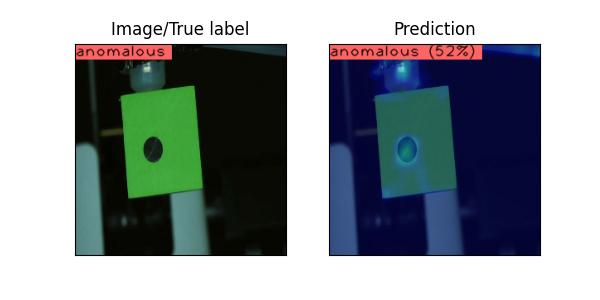

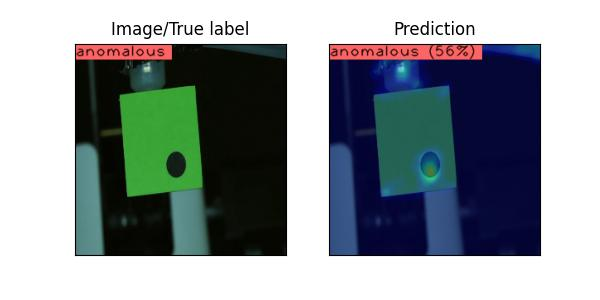

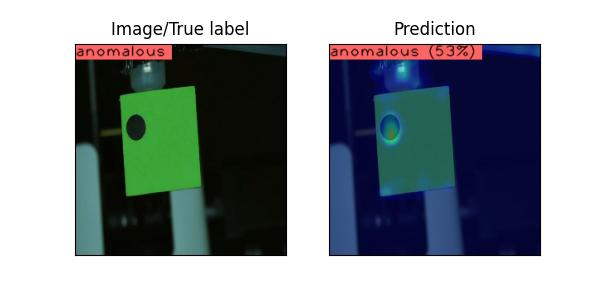

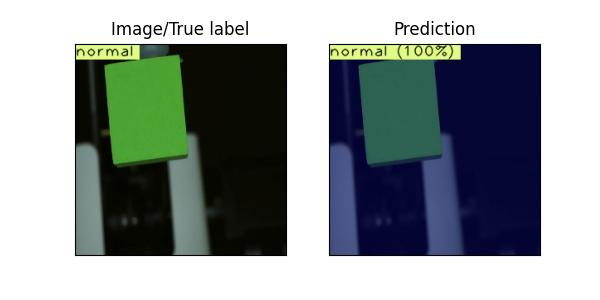

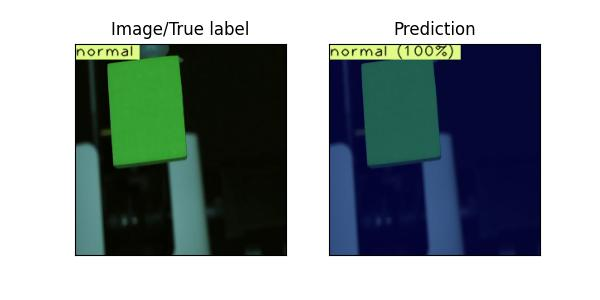

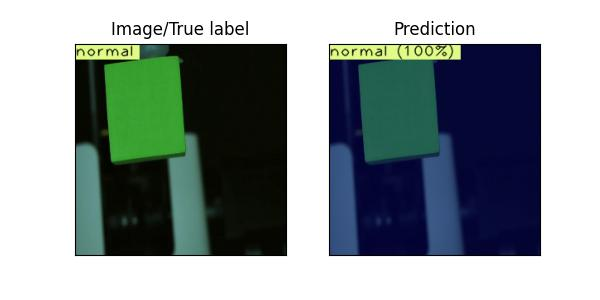

In [11]:
for filename in image_filenames:
    image = Image.open(filename)
    display(image)